Assignment 5: Classification in PyTorch
=======================================


Microsoft Forms Document: https://forms.office.com/r/4PAnYRs2Bf


Task 1: Dataset Loading
-----------------------

We use two different datasets, the spambase dataset https://archive.ics.uci.edu/ml/datasets/spambase for binary classification and the wine dataset https://archive.ics.uci.edu/ml/datasets/wine for categorical classification.
Both datasets are avaliable on the UCI Machine Learning repository.
In the first dataset, the target values are stored in the first column, while the rest is input.
For the second dataset, the target is stored in the last column, the rest is input.

When running with pytorch, samples should be stored as datatype ``torch.tensor``, and split between input sets $\mathbf X = [\vec x^{[1]}, \ldots, \vec x^{[N]}]^T \in \mathbb R^{N\times D}$ and targets.
There is **no need** to add a bias neuron to the input, and the transposition of the data matrix is different from what we have seen before.

For the targets, we have to be more careful as there are differences w.r.t. the applied loss function.
For binary classification, we need $\mathbf T = [[t^{[1]}, \ldots, t^{[N]}]]$ to be in dimension $\mathbb R^{N\times1}$ and of type ``torch.float``.
For categorical classification, we only need the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$ and of type ``torch.long``.

In [30]:
import os
import torch

# download the two dataset files
dataset_files = {
  "spambase.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/",
  "wine.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/"
}
for name, url in dataset_files.items():
  if not os.path.exists(name):
    import urllib.request
    urllib.request.urlretrieve(url+name, name)
    print ("Downloaded datafile", name)


def dataset(dataset_file="wine.data"):
  # read dataset
  data = []
  with open(dataset_file, 'r') as f:
    for row in f:
      row_val = [float(x) for x in row.split(',')]
      data.append(row_val)

  print (f"Loaded dataset with {len(data)} samples")
  
  # convert to torch.tensor
  data = torch.tensor(data)

  if dataset_file == "wine.data":
    # target is in the first column and needs to be converted to long
    X = data[:,1:]
    T = torch.tensor(data[:,0], dtype=torch.long) - 1
  else:
    # target is in the last column and needs to be of type float
    X = data[:,:-1]
    T = torch.tensor(data[:,-1:], dtype=torch.float32)
  
  return X, T

Test 1: Assert Valid Data
-------------------------

Load the wine dataset and make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{N\times D}$ and $\mathbf T \in \mathbb N^N$.
Also assure that all class labels are in the correct range $[0, O-1]$.

Load the spambase data and assure that all dimensions are correct and that class labels are in range $\{0, 1\}$.

In [31]:
# load email data
X, T = dataset("spambase.data")
# assert that everything is correct with the dataset
assert X.shape == (4601,57) and len(T) == 4601, "Shapes are not matching"
assert max(T) <= 1 and min(T) >= 0, "Some label out of range"


# load wine data
X, T = dataset("wine.data")
# assert that everything is correct with the dataset
assert X.shape == (178,13) and len(T) == 178, "Shapes are not matching"


Loaded dataset with 4601 samples
Loaded dataset with 178 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Task 2: Split Training and Validation Data
------------------------------------------

Write a function that splits off training and validation samples from a given dataset.
Use randomly 80% of the data for training, and 20% for validation.

What do we need to assure before splitting?


In [32]:
def split_training_data(X,T,train_percentage=0.8):
  # split into 80/20 training/validation
  perm2 = torch.randperm(X.shape[0])
  train_indices = perm2[:int(train_percentage*X.shape[0])]
  val_indices = perm2[int(train_percentage*X.shape[0]):]

  X_train = X[train_indices,:]
  T_train = T[train_indices]
  X_val = X[val_indices,:]
  T_val = T[val_indices]

  return X_train, T_train, X_val, T_val


Task 3: Input Data Standardization
----------------------------------

Implement a function that standardizes all input data for the training and validation set.
Return the normalized data.

In [33]:
def standardize(X_train, X_val):
  # compute statistics
  mean = torch.mean(X_train, axis=0)
  std = torch.mean(X_train, axis=0)

  # standardize both X_train and X_val
  X_train = (X_train - mean)/std
  X_val = (X_val - mean)/std

  return X_train, X_val


Task 4: Network Implementation
------------------------------

Implement a function that returns a two-layer fully-connected network in pytorch.
Use tanh as activation function, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.

In [34]:
import torch

def Network(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Linear(D,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,O)
  )


Task 5: Accuracy Computation
----------------------------

Implement a function that computes the accuracy of the provided network output (the logits) and the given target values.
Make sure that the implementation supports both binary as well as categorical targets.

In [35]:
def accuracy(Z, T):
  if len(torch.unique(T)) == 2:
    # binary classification
    return (Z >= 0.0).eq(T >= 0.5).sum() / T.numel()
  else:
    # categorical classification
    return torch.mean((torch.argmax(Z, dim=1) == T).float())

Test 2: Test Accuracy Function
------------------------------

Design test data and according logit values with which you can test the correctness of your accuracy function.
Make sure that the accuracy will compute the correct values.
Test both binary and categorical accuracy.

In [36]:
# test binary classification
# ... design test logits and target values
Z = torch.tensor([0.5,-0.2,0.4,0.8,0.2,-0.1,0.9,0.65,0.01])
T = torch.tensor([1,0,1,1,0,0,1,1,0])
# ... test that the expected accuracy is computed
print(accuracy(Z,T))

# test categorical classification
# ... design test logits and target values
Z = torch.tensor([[0.1,0.4,0.5],[0.2,0.6,0.2],[0.3,0.1,0.6]])
T = torch.tensor([[1,0,0],[0,1,0],[0,0,1]])
# ... test that the expected accuracy is computed
accuracy(Z,T)

tensor(0.7778)


tensor(0.3333)

Task 6: Training Loop
---------------------

Implement a function that takes all necessary parameters to run a training on a given dataset.
In this week, we will make use of the whole dataset in each training step, so we will perform gradient descent (not SGD), so there is no need to define anything related to batches.

For each epoch, compute the training set and the validation set accuracy, as well as their losses, and return all of them

In [37]:
def train(X_train,T_train,X_val, T_val,learning_rate=0.01,momentums=0.9,epochs=10000):

  optimizer = torch.optim.SGD(params=network.parameters(),lr=learning_rate,momentum=momentums)

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(epochs):
    # train on training set
    # ... compute network output on training data
    optimizer.zero_grad()
    # train on training set
    # ... compute network output on training data
    Z = network(X_train)
    # ... compute loss from network output and target data
    J = loss(Z, T_train)
    J.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(J.detach().numpy())
    # ... compute training set accuracy
    train_acc.append(accuracy(Z, T_train).detach().numpy())

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z = network(X_val)
      # ... compute loss from network output and target data
      J = loss(Z, T_val)
      # ... remember loss
      val_loss.append(J.detach().numpy())
      # ... compute validation set accuracy
      val_acc.append(accuracy(Z, T_val).detach().numpy())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

Task 7: Plotting Function
-------------------------

Implement a function that takes four lists containing the training loss, the training accuracy, the validation loss and the validation accuracy.
Plot the two losses into one plot, and the two accuracies into another plot.

In [38]:
from matplotlib import pyplot
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.legend()

Task 8: Binary Classification
-----------------------------

Load the data for binary classification, using the ``"spambase.data"`` file.
Split the data into training and validation sets.
Standardize both training and validation input data.

Instantiate a network with the correct number of input neurons, a given number of $K$ hidden neurons and one output neuron.
Instantiate the binary cross entropy loss function.

Train the network with our data for 10'000 epochs and plot the training and validation accuracies and losses.

Loaded dataset with 4601 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


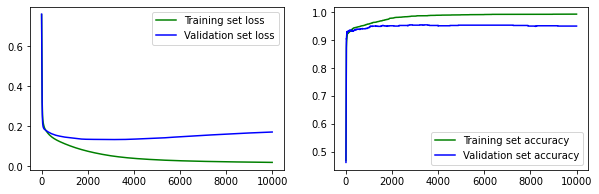

In [39]:
# define loss function
loss = torch.nn.BCEWithLogitsLoss()
# load dataset
X, T = dataset("spambase.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X,T,train_percentage=0.8)
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
network = Network(D=X_train.shape[1], K=50, O=1)

# train network on our data
results = train(X_train,T_train,X_val, T_val,learning_rate=0.01,momentums=0.9,epochs=10000)
# plot the results
plot(*results)

Task 9: Categorical Classification
----------------------------------

Perform the same tasks with the ``"wine.data"`` dataset.
How many output neurons do we need?
Which loss function will we need this time?

How many hidden neurons will we need to get 100% training set accuracy?

Loaded dataset with 178 samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


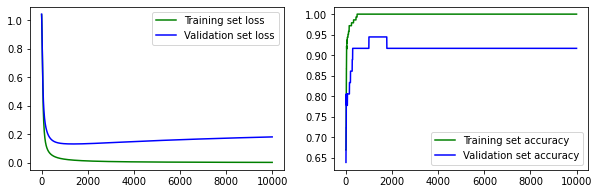

In [40]:
# define loss function
loss = torch.nn.CrossEntropyLoss()
# load dataset
X, T = dataset("wine.data")
# split dataset
X_train, T_train, X_val, T_val = split_training_data(X,T)
T_train = T_train.flatten()
T_val = T_val.flatten()
# standardize input data
X_train, X_val = standardize(X_train, X_val)
# instantiate network
D = X_train.shape[1]
K = 10
O = 3
network = Network(D,K,O)

# train network on our data
results = train(X_train, T_train, X_val, T_val, learning_rate=0.01,momentums=0.9,epochs=10000)

train_loss = results[0]
train_acc = results[1]
val_loss = results[2]
val_acc = results[3]

# plot the results
plot(train_loss,train_acc,val_loss,val_acc)
